In [1]:
## Scientific Computing with Python
import pandas as pd
import numpy as np

## Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Machine Learning Libraries
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.compat import lzip

## File dirtectory
import os
import gc

We will study the rate of cognitive score decline in from the following angles:

    1. With work vs. without work (Retirement)
    2. Different types of work vs. Retirement
    3. Control variable selection using Lasso or step-wise selection.
    4. Likelihood ratio testing whether the full model can be reduced to the simplest model.

# 1. Recall Index Base Model: RwWork * Time

## 1.1 Time as Age

In [44]:
## Take a sample of the first 100 HHIDPN to fit the model
hrsWave = pd.read_csv("../Data/hrsWaveCleaned.csv")
n = 1000
idx = hrsWave["HHIDPN"].unique()[0:n]
idx = hrsWave["HHIDPN"].isin(idx)

X = hrsWave.loc[idx, ["RwAGEM_B", "RwWORK"]]
y = hrsWave.loc[idx, ["RwTR20", "RwMSTOT", "RwAnyCogImp"]]
print(X.shape)
print(y.shape)

(5472, 2)
(5472, 3)


In [61]:
## Interaction model between age in years and RwWORK
df = pd.concat([hrsWave["HHIDPN"], X, y], axis = 1)
df = df.loc[df[["RwAGEM_B", "RwWORK", "RwTR20"]].notna().all(axis = 1)]
df["RwWORK"] = df["RwWORK"].astype("category")

formula1 = "RwTR20 ~ RwAGEM_B * C(RwWORK)"
m1Recall = smf.mixedlm(formula1, data = df, groups = df["HHIDPN"]).fit()
print(m1Recall.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     RwTR20     
No. Observations:     5044        Method:                 REML       
No. Groups:           968         Scale:                  5.6619     
Min. group size:      1           Log-Likelihood:         -12376.4074
Max. group size:      11          Converged:              Yes        
Mean group size:      5.2                                            
---------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                 19.770    0.508  38.927 0.000 18.775 20.766
C(RwWORK)[T.1.0]          -2.973    0.738  -4.029 0.000 -4.419 -1.527
RwAGEM_B                  -0.159    0.008 -20.897 0.000 -0.174 -0.144
RwAGEM_B:C(RwWORK)[T.1.0]  0.053    0.012   4.506 0.000  0.030  0.076
Group Var                  6.195    

1. RwWORK[T.1.0] = -2.973 might imply negative baseline effect of work. The negative effect might due to other confounding variables.
2. RwAGEM_B:RwWORK[T.1.0] = 0.053, however, may impies that RwWork has positive in slowing down cognitive decline

## 1.2 Time as Wave (Categorical)

In [75]:
## Interaction Model between Wave and Time
df = pd.concat([hrsWave[["HHIDPN", "Wave"]], X, y], axis = 1)
df = df.loc[df[["Wave", "RwWORK", "RwTR20"]].notna().all(axis = 1)]

formula2 = "RwTR20 ~ C(Wave) * RwWORK" ## Treat Wave a categorical variable
m2Recall = smf.mixedlm(formula2, data = df, groups = df["HHIDPN"]).fit()
print(m1Recall.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     RwTR20     
No. Observations:     5044        Method:                 REML       
No. Groups:           968         Scale:                  5.6619     
Min. group size:      1           Log-Likelihood:         -12376.4074
Max. group size:      11          Converged:              Yes        
Mean group size:      5.2                                            
---------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                 19.770    0.508  38.927 0.000 18.775 20.766
C(RwWORK)[T.1.0]          -2.973    0.738  -4.029 0.000 -4.419 -1.527
RwAGEM_B                  -0.159    0.008 -20.897 0.000 -0.174 -0.144
RwAGEM_B:C(RwWORK)[T.1.0]  0.053    0.012   4.506 0.000  0.030  0.076
Group Var                  6.195    

In [47]:
print(m1Recall.summary().tables[1].iloc[11:,:])

                       Coef. Std.Err.       z  P>|z|  [0.025 0.975]
RwWORK                 0.265    0.199   1.333  0.182  -0.124  0.654
C(Wave)[T.4]:RwWORK    0.260    0.409   0.636  0.525  -0.541  1.061
C(Wave)[T.5]:RwWORK   -0.071    0.393  -0.180  0.858  -0.840  0.699
C(Wave)[T.6]:RwWORK    0.177    0.359   0.492  0.622  -0.526  0.880
C(Wave)[T.7]:RwWORK   -0.010    0.324  -0.030  0.976  -0.646  0.626
C(Wave)[T.8]:RwWORK    0.300    0.313   0.960  0.337  -0.312  0.913
C(Wave)[T.9]:RwWORK    0.382    0.316   1.211  0.226  -0.237  1.001
C(Wave)[T.10]:RwWORK   0.198    0.334   0.594  0.553  -0.456  0.852
C(Wave)[T.11]:RwWORK   0.822    0.340   2.421  0.015   0.156  1.487
C(Wave)[T.12]:RwWORK  -0.167    0.375  -0.446  0.656  -0.903  0.569
C(Wave)[T.13]:RwWORK   0.809    0.413   1.960  0.050   0.000  1.618
Group Var              6.923    0.187                              


1. Wave is fitted as a categorical variable, indicating time effect. For each wave, the negative effect of work magnifies as the wave increases.
2. The interaction between work and wave are generally positive, except in wave 4. The generally positive interaction implies protective effect of working to the absolute recall index.
3. Most of interaction terms are not staistically significant >= 0.05

## 1.3 Absolute Recall Index to Relative Recall Index at 65 Years of Age 

In [51]:
def convertToPct(df, timeCol, cogniCols):
    '''
    For each individual, find the time that is the closest to 0, treat it as 1. 
    Compute the percentage of the cognitive scores relative to the reference

    df: the dataframe
    timeCol: column name of time
    cogniCols: a list of cognitive score columns

    Returns: 
    a dataframe with cogni columns transformed
    '''
    df = df.copy()
    for cogniCol in cogniCols:
        # Find baseline (closest to age 65) for each individual
        baseline = df.loc[df.groupby('HHIDPN')[timeCol].apply(lambda x: (x - 65).abs().idxmin()), 
                          ['HHIDPN', cogniCol]]
        baseline = baseline.rename(columns={cogniCol: f"{cogniCol}_baseline"})
        # Merge baseline back to main df
        df = df.merge(baseline, on='HHIDPN', how='left')
        # Compute percent
        df[f"{cogniCol}_pct"] = df[cogniCol] / df[f"{cogniCol}_baseline"] #* 100
        df.drop(columns=[f"{cogniCol}_baseline"], inplace=True)
    return df

dfPerc = df.copy()
dfPerc = convertToPct(dfPerc, "RwAGEM_B", ["RwTR20"])
dfPerc.head(10)

,HHIDPN,Wave,RwAGEM_B,RwWORK,RwTR20,RwMSTOT,RwAnyCogImp,RwTR20_pct
0,2010,3,56.583333,0.0,9.0,11.0,0.0,1.125000
1,2010,5,60.000000,0.0,8.0,6.0,0.0,1.000000
2,3010,3,55.083333,1.0,20.0,15.0,0.0,3.333333
3,3010,6,60.833333,1.0,18.0,13.0,0.0,3.000000
4,3010,7,63.083333,1.0,7.0,11.0,0.0,1.166667
5,3010,8,64.750000,0.0,6.0,14.0,0.0,1.000000
6,3010,9,66.666667,0.0,12.0,14.0,0.0,2.000000
7,3010,10,69.250000,0.0,7.0,10.0,0.0,1.166667
8,3010,11,71.083333,0.0,4.0,8.0,0.0,0.666667
9,3020,3,52.416667,1.0,12.0,13.0,0.0,1.200000


In [77]:
## Interaction Model between Wave and Time
formula3 = "RwTR20_pct ~ C(Wave) * RwWORK" ## Treat Wave a categorical variable
dfPerc.dropna(inplace=True, axis = 0)
m3Recall = smf.mixedlm(formula3, data = dfPerc, groups = dfPerc["HHIDPN"]).fit()
print(m3Recall.summary())

C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\regression\mixed_linear_model.py:508: RuntimeWarning: invalid value encountered in subtract
  return rhs / s - ql / s**2
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: RwTR20_pct
No. Observations:  5041    Method:             REML      
No. Groups:        968     Scale:              nan       
Min. group size:   1       Log-Likelihood:     nan       
Max. group size:   11      Converged:          No        
Mean group size:   5.2                                   
---------------------------------------------------------
                     Coef. Std.Err. z P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept                                                
C(Wave)[T.4]                                             
C(Wave)[T.5]                                             
C(Wave)[T.6]                                             
C(Wave)[T.7]                                             
C(Wave)[T.8]                                             
C(Wave)[T.9]                                             
C(Wave)[T.10]           

Converting RwTR20 to percentage is not a good idea.

## 1.4 Add Age to Wave * RwWORK

In [60]:
formula4 = "RwTR20 ~ C(Wave) * RwWORK + RwAGEM_B" ## Treat Wave a categorical variable
m4Recall = smf.mixedlm(formula4, data = df, groups = df["HHIDPN"]).fit()
print(m4Recall.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   RwTR20     
No. Observations:   5044      Method:               REML       
No. Groups:         968       Scale:                5.6474     
Min. group size:    1         Log-Likelihood:       -12369.0831
Max. group size:    11        Converged:            Yes        
Mean group size:    5.2                                        
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            19.129    0.878 21.799 0.000 17.409 20.849
C(Wave)[T.4]          0.810    0.258  3.141 0.002  0.305  1.316
C(Wave)[T.5]          0.748    0.245  3.046 0.002  0.266  1.229
C(Wave)[T.6]          0.575    0.237  2.427 0.015  0.111  1.039
C(Wave)[T.7]          0.375    0.242  1.546 0.122 -0.100  0.850
C(Wave)[T.8]          0.402    0.250  1.609 0.108 -0.

In [120]:
print(m4Recall.summary().tables[1].iloc[11:,:])

                       Coef. Std.Err.       z  P>|z|  [0.025  0.975]
RwWORK                 0.127    0.198   0.643  0.520  -0.260   0.514
C(Wave)[T.4]:RwWORK    0.206    0.408   0.507  0.612  -0.592   1.005
C(Wave)[T.5]:RwWORK    0.008    0.392   0.020  0.984  -0.760   0.776
C(Wave)[T.6]:RwWORK    0.225    0.358   0.629  0.529  -0.476   0.927
C(Wave)[T.7]:RwWORK    0.048    0.324   0.149  0.882  -0.586   0.682
C(Wave)[T.8]:RwWORK    0.367    0.312   1.177  0.239  -0.244   0.978
C(Wave)[T.9]:RwWORK    0.449    0.315   1.427  0.154  -0.168   1.066
C(Wave)[T.10]:RwWORK   0.253    0.333   0.761  0.446  -0.399   0.906
C(Wave)[T.11]:RwWORK   0.895    0.339   2.644  0.008   0.232   1.559
C(Wave)[T.12]:RwWORK  -0.093    0.375  -0.249  0.804  -0.827   0.641
C(Wave)[T.13]:RwWORK   0.837    0.411   2.035  0.042   0.031   1.643
RwAGEM_B              -0.155    0.016  -9.707  0.000  -0.186  -0.124
Group Var              6.181    0.169                               


In [78]:
print("Time as Age Fitness ------")
print(m1Recall.summary().tables[0][[2,3]])

print("Time as Wave Fitness ------")
print(m2Recall.summary().tables[0][[2,3]])

print("Relative Recall Index Fitness ------")
print(m3Recall.summary().tables[0][[2,3]])

print("(Wave * Work + Age) Fitness ------")
print(m4Recall.summary().tables[0][[2,3]])

Time as Age Fitness ------
                     2            3
0  Dependent Variable:       RwTR20
1              Method:         REML
2               Scale:       5.6619
3      Log-Likelihood:  -12376.4074
4           Converged:          Yes
5                                  
Time as Wave Fitness ------
                     2            3
0  Dependent Variable:       RwTR20
1              Method:         REML
2               Scale:       5.6510
3      Log-Likelihood:  -12411.0259
4           Converged:          Yes
5                                  
Relative Recall Index Fitness ------
                     2           3
0  Dependent Variable:  RwTR20_pct
1              Method:        REML
2               Scale:         nan
3      Log-Likelihood:         nan
4           Converged:          No
5                                 
(Wave * Work + Age) Fitness ------
                     2            3
0  Dependent Variable:       RwTR20
1              Method:         REML
2               

Model 4: (Wave * Work + Age) Fitness , shows better fitness

# 2. Recall Index Standard Model: Wave*Occupation Category + Age

In [2]:
formula5 = "RwTR20 ~ C(RwJOCCSD, Treatment(reference='Retired')) * Wave + RwAGEM_B"
df["RwJOCCSD"] = hrsWave["RwJOCCSD"]
df.dropna(axis=0, inplace=True)
m5Recall = smf.mixedlm(formula5, data = df, groups = df["HHIDPN"]).fit()
print(m5Recall.summary())

NameError: name 'hrsWave' is not defined

In [ ]:
m5Coef = m5Recall.summary().tables[1]
m5Coef = m5Coef.reset_index()
m5Coef

# 3. Visualizations

In [5]:
hrsWave = pd.read_csv("../Data/hrsWaveCleaned.csv")

## Filter subjects older than 50 years
hrsWave = hrsWave.query("RwAGEM_B >= 50")
## Cut Age Ranges into bins
hrsWave["RwAgeBand"] = pd.cut(hrsWave["RwAGEM_B"],
                              list(range(50, 95, 5)),
                              include_lowest = True)
print(hrsWave.info())

<class 'pandas.core.frame.DataFrame'>
Index: 130687 entries, 0 to 145624
Data columns (total 47 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   Unnamed: 0.1  130687 non-null  int64   
 1   Unnamed: 0    130687 non-null  int64   
 2   index         130687 non-null  int64   
 3   HHIDPN        130687 non-null  int64   
 4   Wave          130687 non-null  int64   
 5   RwTR20        116782 non-null  float64 
 6   RwMSTOT       116782 non-null  float64 
 7   RwLOST_x      130687 non-null  int64   
 8   RwWANDER_x    130687 non-null  int64   
 9   RwALONE_x     130687 non-null  int64   
 10  RwHALUC_x     130687 non-null  int64   
 11  RwWORK        130364 non-null  float64 
 12  RwJHOURS      25986 non-null   float64 
 13  RwWGIHR       22561 non-null   float64 
 14  RwJPHYS       25507 non-null   float64 
 15  RwJLIFT       25511 non-null   float64 
 16  RwJSTRES      25938 non-null   float64 
 17  RwJSTOOP      25505 non-null   flo

In [ ]:
hrsWave.drop(["Unnamed: 0.1", "Unnamed: 0", "index"], axis =1, inplace = True)
hrsWave.head()

hrsWave.drop(['RwLOST_x', 'RwWANDER_x',
       'RwALONE_x', 'RwHALUC_x',
       'RwLOST_y', 'RwWANDER_y', 
       'RwHALUC_y', 'RwALONE_y'], axis = 1, inplace=True)

In [ ]:
hrsWave["RwAgeBand"] = pd.cut(hrsWave["RwAGEM_B"],
                              list(range(50, 95, 5)))
hrsWave["RwAgeBand"] = hrsWave["RwAgeBand"].astype("category")

0         (55, 60]
1         (55, 60]
2         (55, 60]
3         (60, 65]
4         (60, 65]
            ...   
145614    (55, 60]
145615    (50, 55]
145619    (50, 55]
145623    (50, 55]
145624    (55, 60]
Name: RwAgeBand, Length: 130687, dtype: category
Categories (8, interval[int64, right]): [(50, 55] < (55, 60] < (60, 65] < (65, 70] < (70, 75] < (75, 80] < (80, 85] < (85, 90]]

In [46]:
## Rake the first 1000 samples
n = 5000
hhidpn = np.random.choice(hrsWave["HHIDPN"].unique(), size = n)
idx = hrsWave["HHIDPN"].isin(hhidpn)
df = hrsWave.loc[idx, :]

C:\Users\86139\AppData\Local\Temp\ipykernel_9204\74225853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RwAgeBand"] = pd.cut(df["RwAGEM_B"],


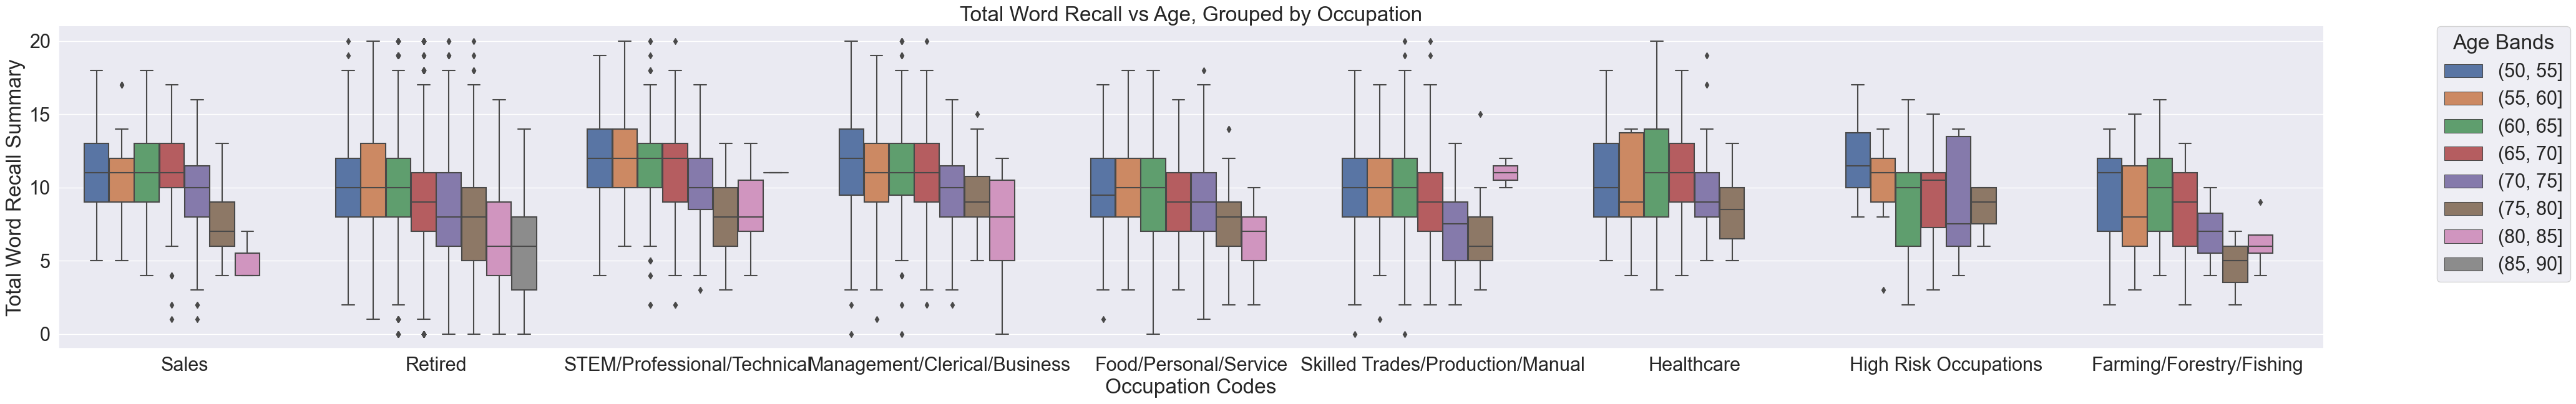

In [ ]:
## Grouped by occupations, what are median and spread of recall index as age increase?
df["RwAgeBand"] = pd.cut(df["RwAGEM_B"],
                              list(range(50, 95, 5)))
sns.set_context("notebook", font_scale=2)
g = sns.catplot(
    data=df, x="RwJOCCSD", y="RwTR20", hue="RAEDYRS",
    kind="box",
    height=7, aspect=6,  # aspect*height = width in inches
    legend_out=True,
    margin_titles=True,
    legend=None
)
plt.legend(
    title = "Age Bands",
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    borderaxespad=0.)
plt.title("Total Word Recall vs Age, Grouped by Occupation")
g.set_axis_labels(x_var = "Occupation Codes", 
                  y_var = "Total Word Recall Summary")

plt.tight_layout()

<Figure size 4000x500 with 0 Axes>

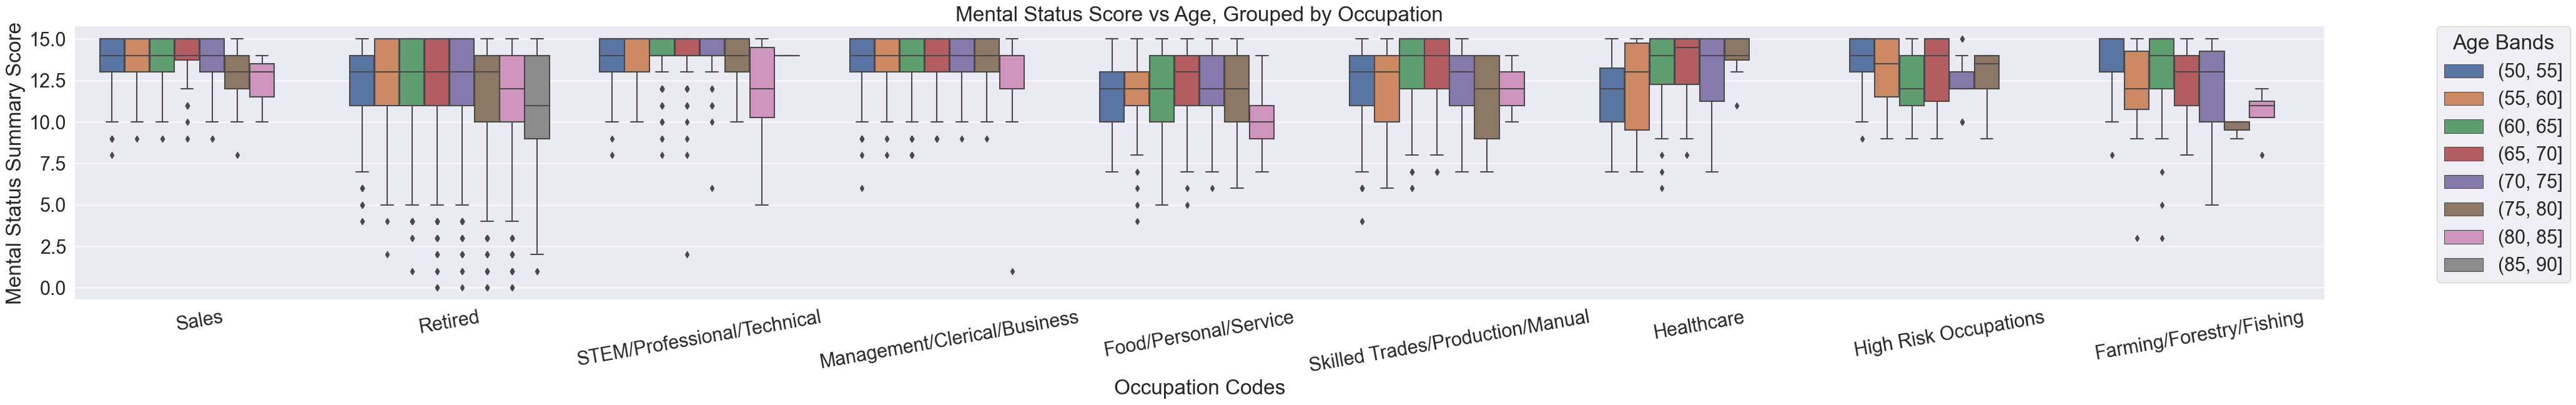

In [102]:
## Grouped by occupations, what are median and spread of recall index as age increase?
plt.figure(figsize=(40,5))
sns.set_context("notebook", font_scale=2)
g = sns.catplot(
    data=df, x="RwJOCCSD", y="RwMSTOT", hue="RwAgeBand",
    kind="box",
    height=7, aspect=6,  # aspect*height = width in inches
    legend_out=True,
    margin_titles=True,
    legend=None
)
plt.legend(
    title = "Age Bands",
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    borderaxespad=0.)
plt.title("Mental Status Score vs Age, Grouped by Occupation")
plt.xticks(rotation = 10)
g.set_axis_labels(x_var = "Occupation Codes", 
                  y_var = "Mental Status Summary Score")

plt.tight_layout()

C:\Users\86139\AppData\Local\Temp\ipykernel_9204\157100392.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RwAgeBand"] = pd.cut(df["RwAGEM_B"],
C:\Users\86139\AppData\Local\Temp\ipykernel_9204\157100392.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_df = df.groupby(['RwJOCCSD', 'RwAgeBand'], as_index=False)['RwTR20'].median()
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is d

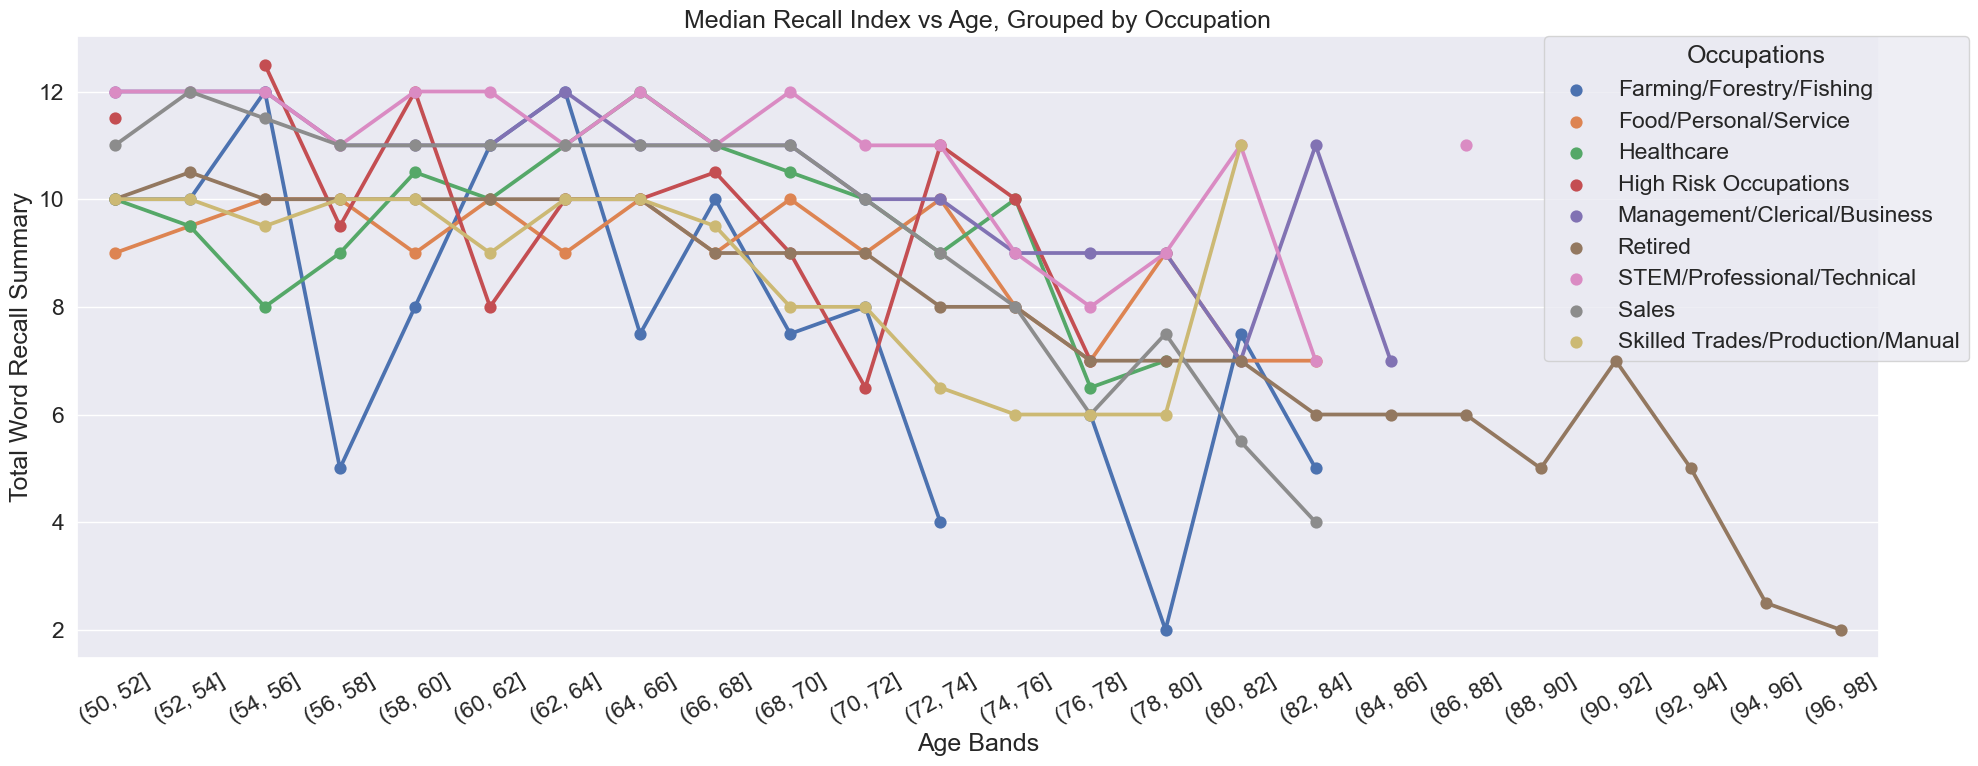

In [82]:
# Compute median RwTR20 for each RwJOCCSD and Wave
df["RwAgeBand"] = pd.cut(df["RwAGEM_B"],
                              list(range(50, 100, 2)))

median_df = df.groupby(['RwJOCCSD', 'RwAgeBand'], as_index=False)['RwTR20'].median()

plt.figure(figsize = (20, 8))
sns.set_theme(context = "notebook", font_scale=1.5)
sns.pointplot(
    data=median_df,
    x="RwAgeBand", y="RwTR20", hue="RwJOCCSD"
)
plt.title("Median Recall Index vs Age, Grouped by Occupation")
plt.legend(title="Occupations", bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
plt.xticks(rotation=30)
plt.xlabel("Age Bands")
plt.ylabel("Total Word Recall Summary")
plt.tight_layout()

C:\Users\86139\AppData\Local\Temp\ipykernel_9204\1010623748.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_df = df.groupby(['RwJOCCSD', 'RwAgeBand'], as_index=False)['RwMSTOT'].median()
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:641: F

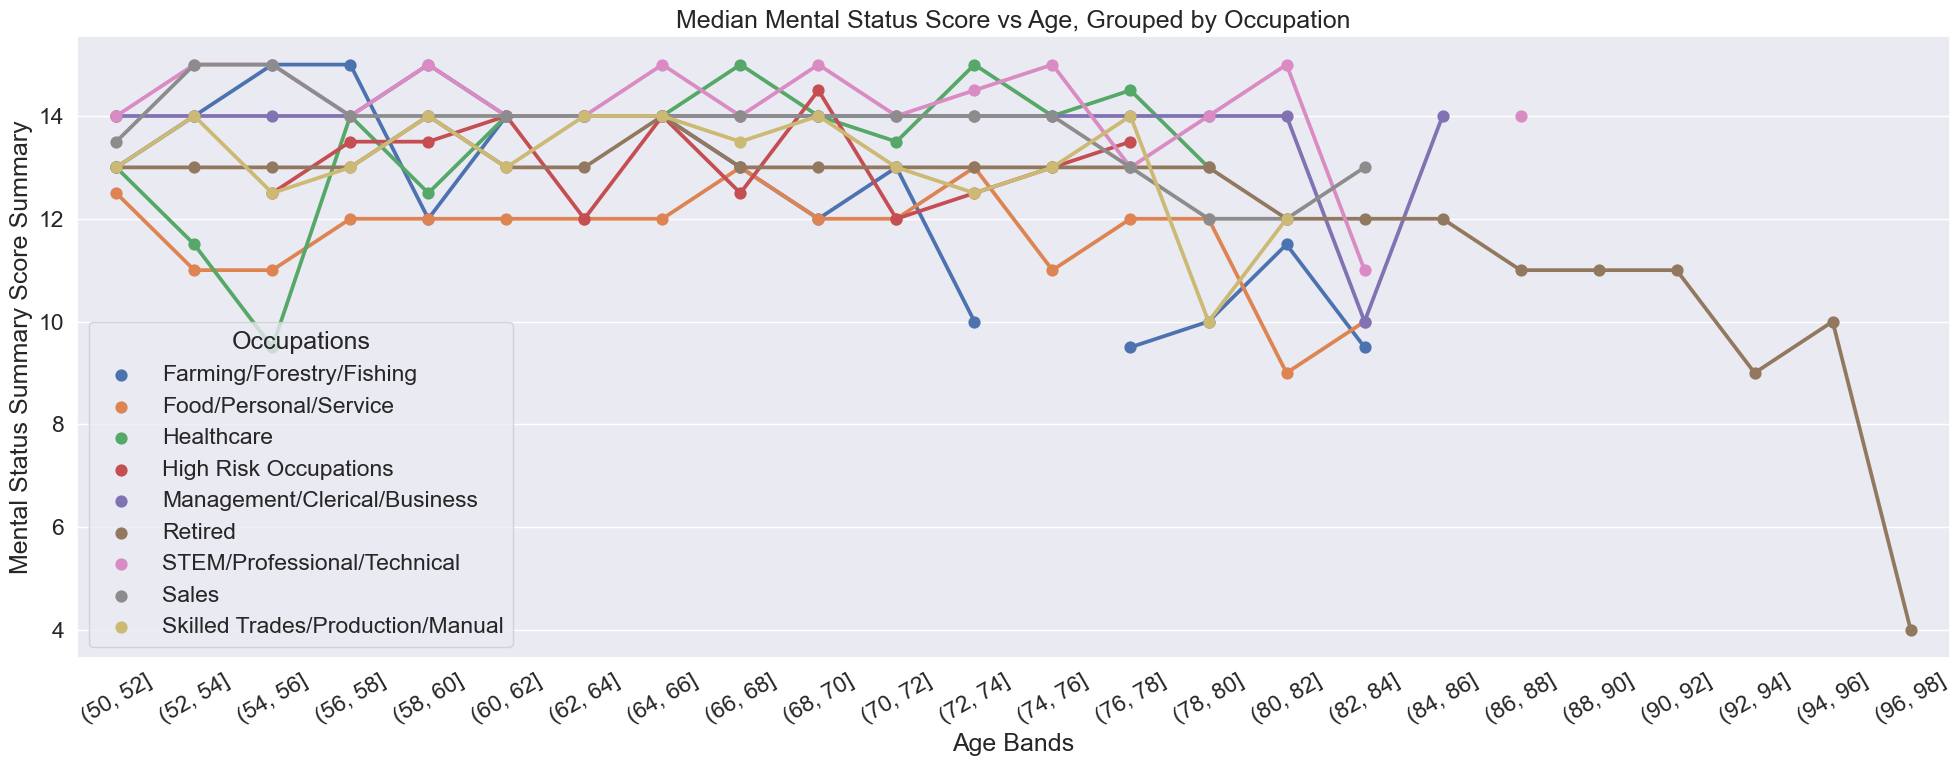

In [108]:
# Compute median RwTR20 for each RwJOCCSD and Wave

median_df = df.groupby(['RwJOCCSD', 'RwAgeBand'], as_index=False)['RwMSTOT'].median()

plt.figure(figsize = (20, 8))
sns.set_theme(context = "notebook", font_scale=1.5)
sns.pointplot(
    data=median_df,
    x="RwAgeBand", y="RwMSTOT", hue="RwJOCCSD"
)
plt.title("Median Mental Status Score vs Age, Grouped by Occupation")
plt.legend(title="Occupations", loc='lower left')
plt.xticks(rotation=30)
plt.xlabel("Age Bands")
plt.ylabel("Mental Status Summary Score Summary")
plt.tight_layout()

C:\Users\86139\AppData\Local\Temp\ipykernel_9204\157100392.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RwAgeBand"] = pd.cut(df["RwAGEM_B"],
C:\Users\86139\AppData\Local\Temp\ipykernel_9204\157100392.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_df = df.groupby(['RwJOCCSD', 'RwAgeBand'], as_index=False)['RwTR20'].median()
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is d

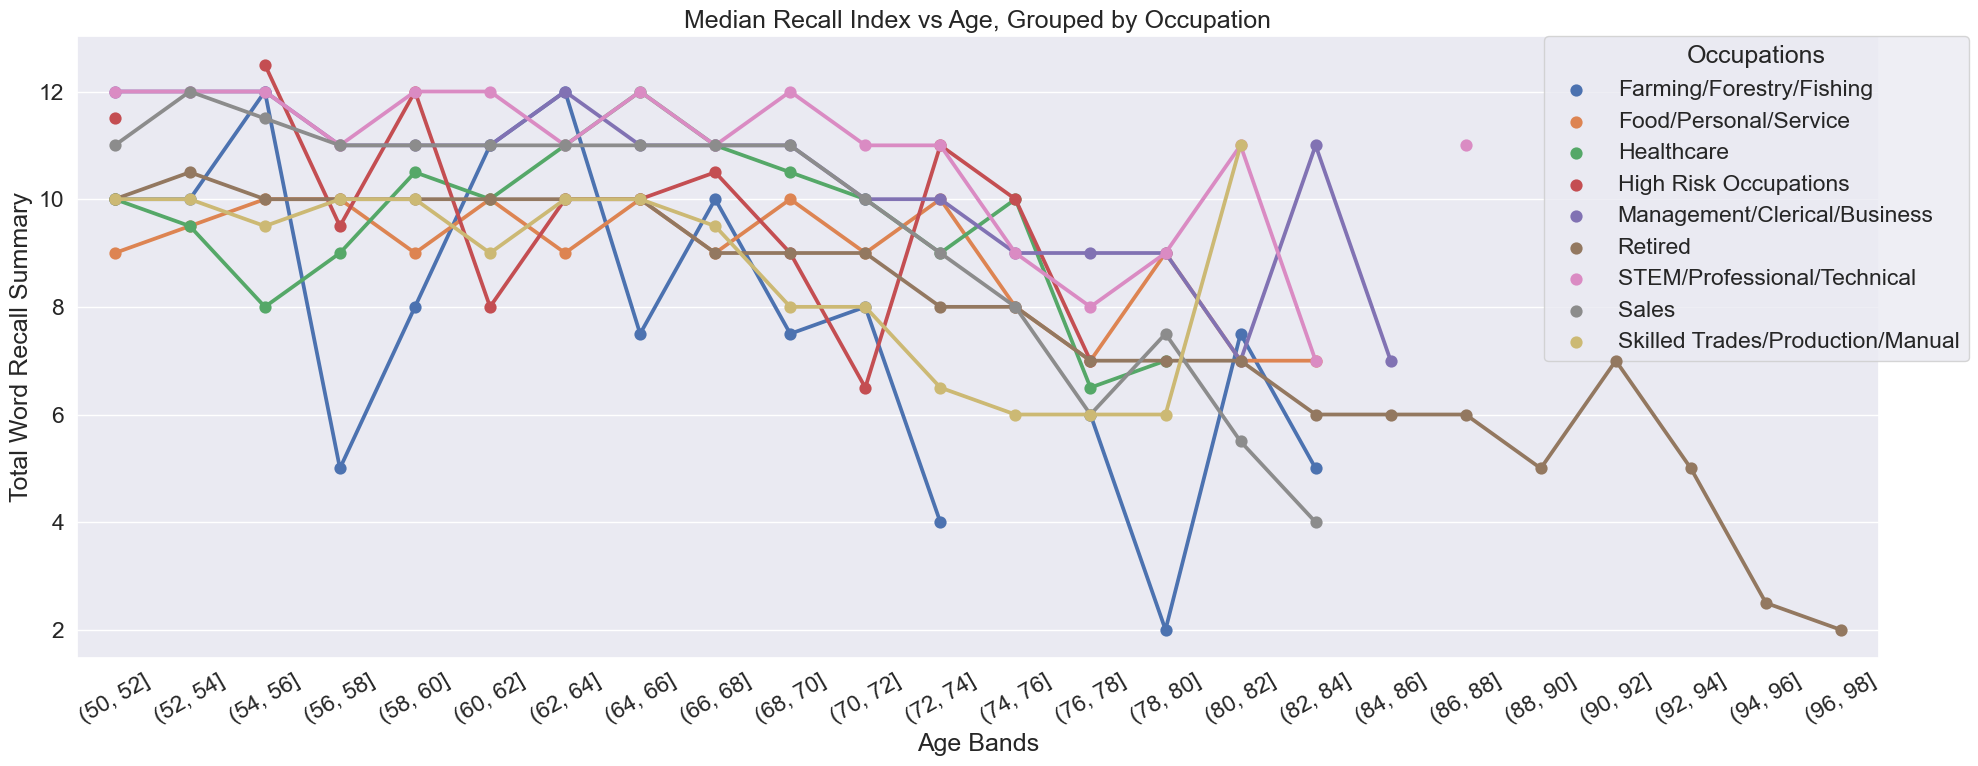

In [ ]:
# Compute median RwTR20 for each RwJOCCSD and Wave
df["RwAgeBand"] = pd.cut(df["RwAGEM_B"],
                              list(range(50, 100, 2)))

median_df = df.groupby(['RwJOCCSD', 'RwAgeBand'], as_index=False)['RwTR20'].median()

plt.figure(figsize = (20, 8))
sns.set_theme(context = "notebook", font_scale=1.5)
sns.pointplot(
    data=median_df,
    x="RwAgeBand", y="RwTR20", hue="RwJOCCSD"
)
plt.title("Median Recall Index vs Age, Grouped by Occupation")
plt.legend(title="Occupations", bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
plt.xticks(rotation=30)
plt.xlabel("Age Bands")
plt.ylabel("Total Word Recall Summary")
plt.tight_layout()

In [86]:
df.columns

Index(['HHIDPN', 'Wave', 'RwTR20', 'RwMSTOT', 'RwWORK', 'RwJHOURS', 'RwWGIHR',
       'RwJPHYS', 'RwJLIFT', 'RwJSTRES', 'RwJSTOOP', 'RwJSIGHT', 'RwCENREG',
       'RwMSTAT', 'RwAGEM_B', 'RwLIVBRO', 'RwHIBP', 'RwDIAB', 'RwCANCR',
       'RwLUNG', 'RwHEART', 'RwSTROK', 'RwPSYCH', 'RwATRAN', 'RwVIGACT',
       'RwSMOKEV', 'RwDRINK', 'RwPhyLim', 'RwCogLim', 'RwJOCCSD',
       'RwAnyCogImp', 'RwLOST', 'RwWANDER', 'RwHALUC', 'RwALONE', 'RwAgeBand'],
      dtype='object')

In [135]:
median_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   RwJOCCSD   288 non-null    object  
 1   RwAgeBand  288 non-null    category
 2   RwPhyLim   288 non-null    bool    
 3   RwCogLim   288 non-null    bool    
 4   RwTR20     222 non-null    float64 
dtypes: bool(2), category(1), float64(1), object(1)
memory usage: 5.9+ KB


C:\Users\86139\AppData\Local\Temp\ipykernel_9204\183961850.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_df = df.groupby(['RwJOCCSD', 'RwAgeBand', 'RwPhyLim', 'RwCogLim'], as_index=False)['RwTR20'].median()
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn

<Figure size 4000x4000 with 0 Axes>

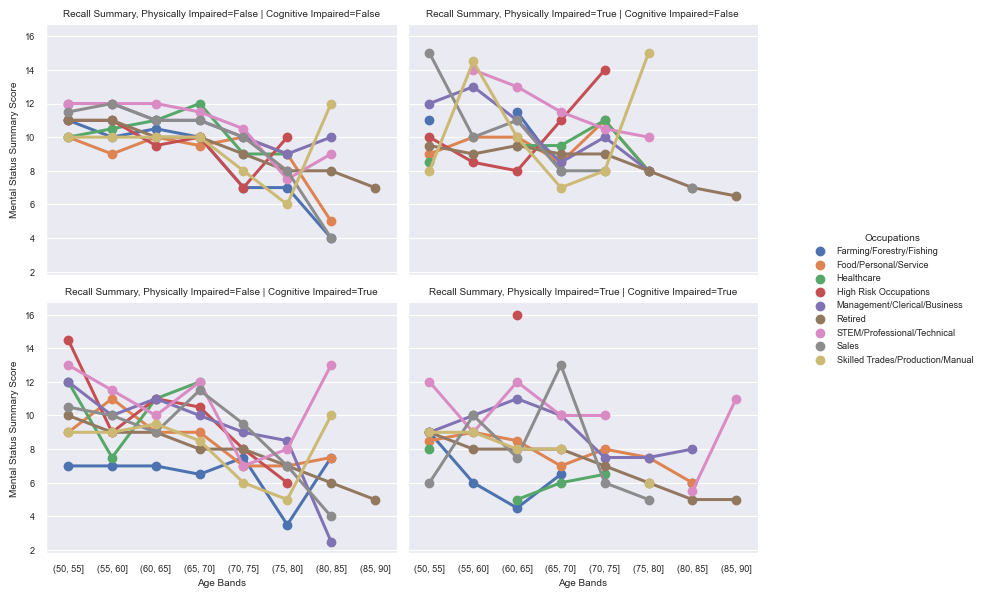

In [ ]:
## Facet by Cognitive and Physical Limitations
median_df = df.groupby(['RwJOCCSD', 'RwAgeBand', 'RwPhyLim', 'RwCogLim'], as_index=False)['RwTR20'].median()

plt.figure(figsize = (40, 40))
sns.set_theme(context = "paper", font_scale = 0.75)
g = sns.FacetGrid(median_df, col='RwPhyLim', row='RwCogLim')
g.map_dataframe(sns.pointplot, x="RwAgeBand", y="RwTR20", 
      hue="RwJOCCSD", palette="deep")
g.add_legend(title="Occupations", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
g.set_titles("Recall Summary, Physically Impaired={col_name} | Cognitive Impaired={row_name}")
g.set_axis_labels(x_var = "Age Bands", y_var= "Mental Status Summary Score")
plt.tight_layout()

C:\Users\86139\AppData\Local\Temp\ipykernel_9204\2220134153.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_df = df.groupby(['RwJOCCSD', 'RwAgeBand', 'RwPhyLim', 'RwCogLim'], as_index=False)['RwMSTOT'].median()
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seabo

<Figure size 4000x4000 with 0 Axes>

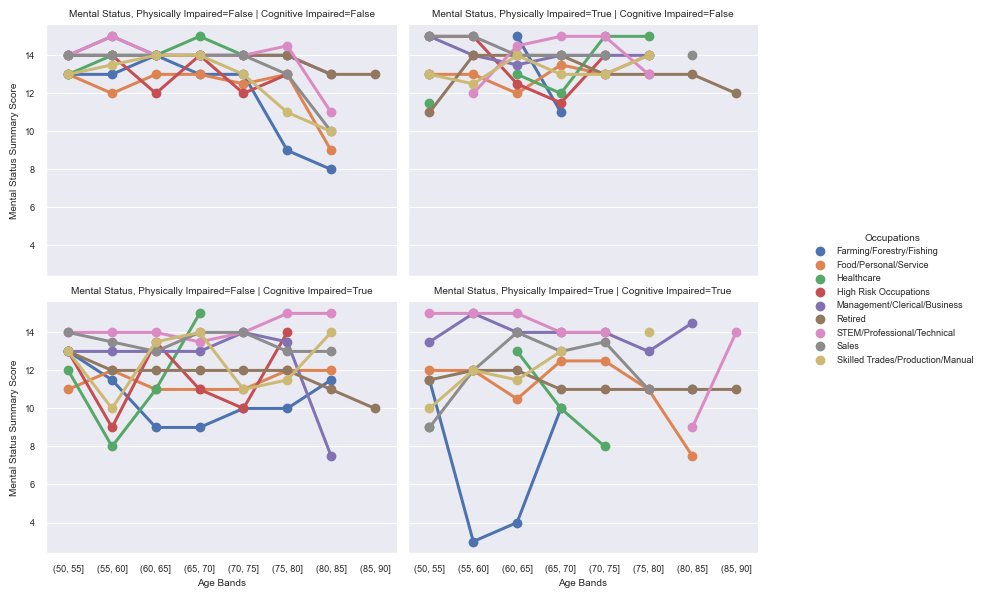

In [144]:
## Median mental status Facet by Cognitive and Physical Limitations
median_df = df.groupby(['RwJOCCSD', 'RwAgeBand', 'RwPhyLim', 'RwCogLim'], as_index=False)['RwMSTOT'].median()

plt.figure(figsize = (40, 40))
sns.set_theme(context = "paper", font_scale = 0.75)
g = sns.FacetGrid(median_df, col='RwPhyLim', row='RwCogLim')
g.map_dataframe(sns.pointplot, x="RwAgeBand", y="RwMSTOT", 
      hue="RwJOCCSD", palette="deep")
g.add_legend(title="Occupations", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
g.set_titles("Mental Status, Physically Impaired={col_name} | Cognitive Impaired={row_name}")
g.set_axis_labels(x_var = "Age Bands", y_var= "Mental Status Summary Score")
plt.tight_layout()

## 3.2 Integrate Non-Wave-Specific Variables

In [154]:
hrsAll = pd.read_csv("../Data/joinedHRSALL.csv")
print(hrsAll.head())
print(hrsAll.info())

       HHIDPN  RAGENDER  RARACEM  RAEDYRS  RAEVBRN
0      1010.0       1.0      1.0     16.0      NaN
1      2010.0       2.0      1.0      8.0      8.0
2      3010.0       1.0      1.0     12.0      4.0
3      3020.0       2.0      1.0     16.0      1.0
4  10001010.0       1.0      1.0     12.0      0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45234 entries, 0 to 45233
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   HHIDPN    45234 non-null  float64
 1   RAGENDER  45234 non-null  float64
 2   RARACEM   44626 non-null  float64
 3   RAEDYRS   44585 non-null  float64
 4   RAEVBRN   43261 non-null  float64
dtypes: float64(5)
memory usage: 1.7 MB
None


In [155]:
hrsAll["RAGENDER"] = hrsAll["RAGENDER"].map({1:"M", 2:"F"}).astype("category")
hrsAll["RARACEM"] = hrsAll["RARACEM"].map({1:"White", 2:"Black", 3:"Others"}).astype("category")
hrsAll["RAEDYRS"] = pd.cut(hrsAll["RAEDYRS"], bins = list(range(0, 26, 2))).astype("category")
hrsAll["RAEVBRN"] = pd.cut(hrsAll["RAEVBRN"], bins = [0, 3, 8, 13], labels=[0,1,2]).astype("category")
hrsAll.head()

,HHIDPN,RAGENDER,RARACEM,RAEDYRS,RAEVBRN
0,1010.0,M,White,"(14, 16]",NaN
1,2010.0,F,White,"(6, 8]",1
2,3010.0,M,White,"(10, 12]",1
3,3020.0,F,White,"(14, 16]",0
4,10001010.0,M,White,"(10, 12]",NaN


In [156]:
df = pd.merge(df, hrsAll, on="HHIDPN", how = "left")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21148 entries, 0 to 21147
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   HHIDPN       21148 non-null  int64   
 1   Wave         21148 non-null  int64   
 2   RwTR20       18837 non-null  float64 
 3   RwMSTOT      18837 non-null  float64 
 4   RwWORK       21104 non-null  float64 
 5   RwJHOURS     4106 non-null   float64 
 6   RwWGIHR      3614 non-null   float64 
 7   RwJPHYS      4008 non-null   float64 
 8   RwJLIFT      4009 non-null   float64 
 9   RwJSTRES     4095 non-null   float64 
 10  RwJSTOOP     4009 non-null   float64 
 11  RwJSIGHT     4073 non-null   float64 
 12  RwCENREG     21148 non-null  float64 
 13  RwMSTAT      21135 non-null  float64 
 14  RwAGEM_B     21148 non-null  float64 
 15  RwLIVBRO     21148 non-null  float64 
 16  RwHIBP       21148 non-null  float64 
 17  RwDIAB       21135 non-null  float64 
 18  RwCANCR      21130 non-nul

C:\Users\86139\AppData\Local\Temp\ipykernel_9204\493882628.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_df = df.groupby(['RwJOCCSD', 'RAEDYRS'], as_index=False)['RwTR20'].median()
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:641: Futur

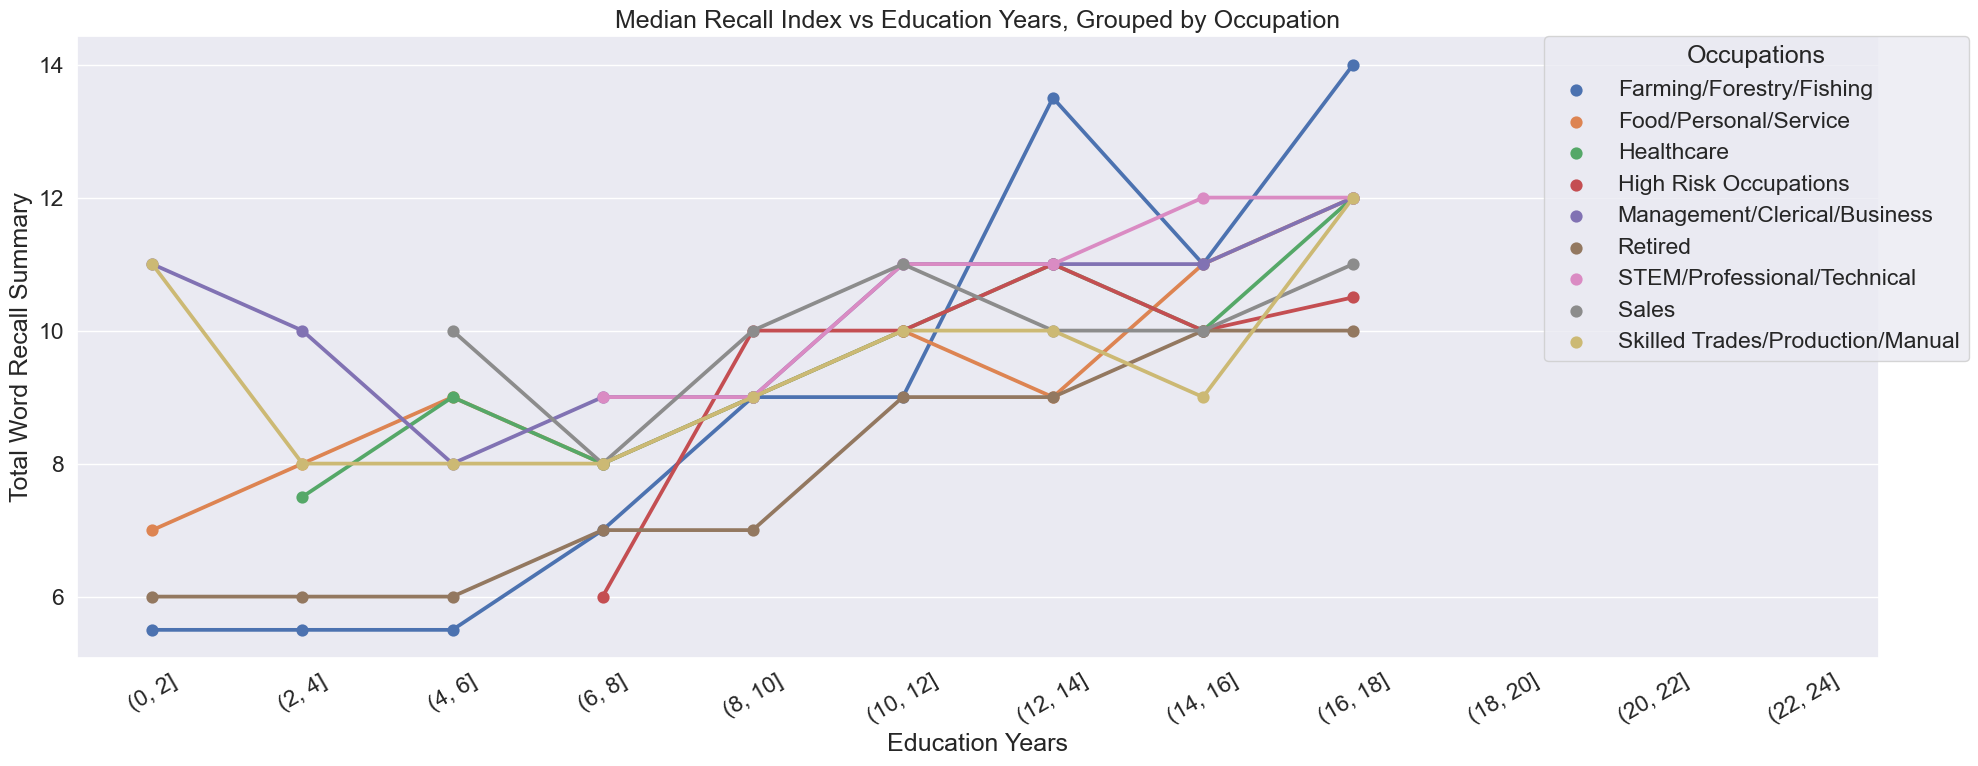

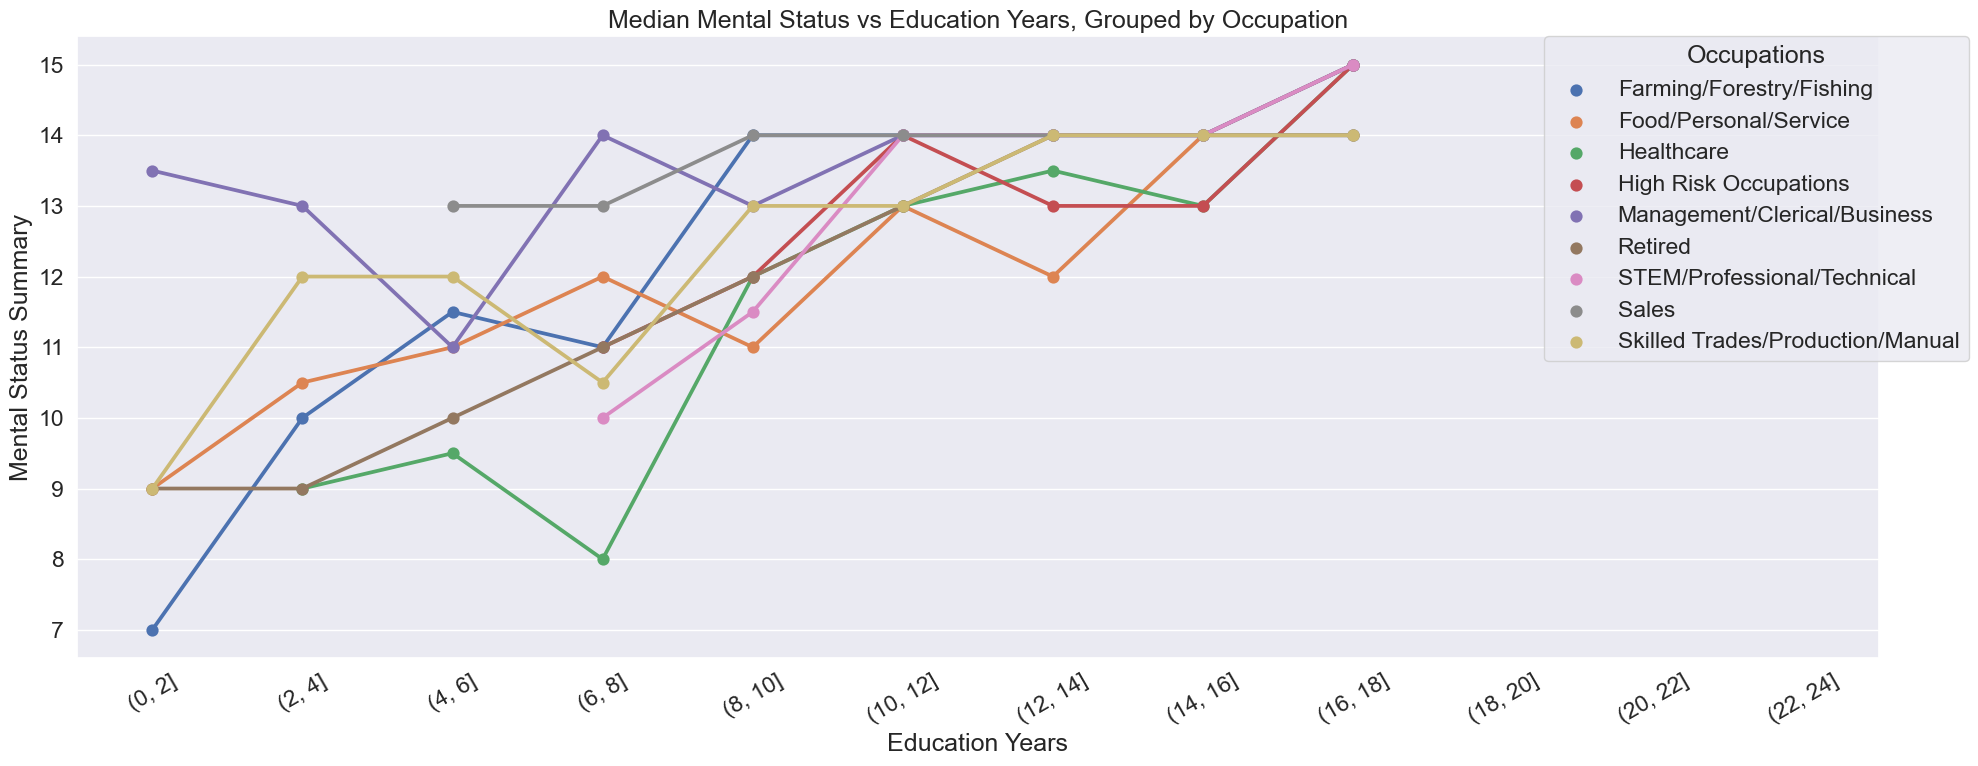

In [160]:
median_df = df.groupby(['RwJOCCSD', 'RAEDYRS'], as_index=False)['RwTR20'].median()

plt.figure(figsize = (20, 8))
sns.set_theme(context = "notebook", font_scale=1.5)
sns.pointplot(
    data=median_df,
    x="RAEDYRS", y="RwTR20", hue="RwJOCCSD"
)
plt.title("Median Recall Index vs Education Years, Grouped by Occupation")
plt.legend(title="Occupations", bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
plt.xticks(rotation=30)
plt.xlabel("Education Years")
plt.ylabel("Total Word Recall Summary")
plt.tight_layout()

median_df = df.groupby(['RwJOCCSD', 'RAEDYRS'], as_index=False)['RwMSTOT'].median()

plt.figure(figsize = (20, 8))
sns.set_theme(context = "notebook", font_scale=1.5)
sns.pointplot(
    data=median_df,
    x="RAEDYRS", y="RwMSTOT", hue="RwJOCCSD"
)
plt.title("Median Mental Status vs Education Years, Grouped by Occupation")
plt.legend(title="Occupations", bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
plt.xticks(rotation=30)
plt.xlabel("Education Years")
plt.ylabel("Mental Status Summary")
plt.tight_layout()

### 3.2.1 Facet by Gender and Race

C:\Users\86139\AppData\Local\Temp\ipykernel_9204\3541189264.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_df = df.groupby(['RwJOCCSD', 'RAEDYRS', 'RAGENDER', 'RARACEM'], as_index=False)['RwTR20'].median()
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\c

<Figure size 6000x4000 with 0 Axes>

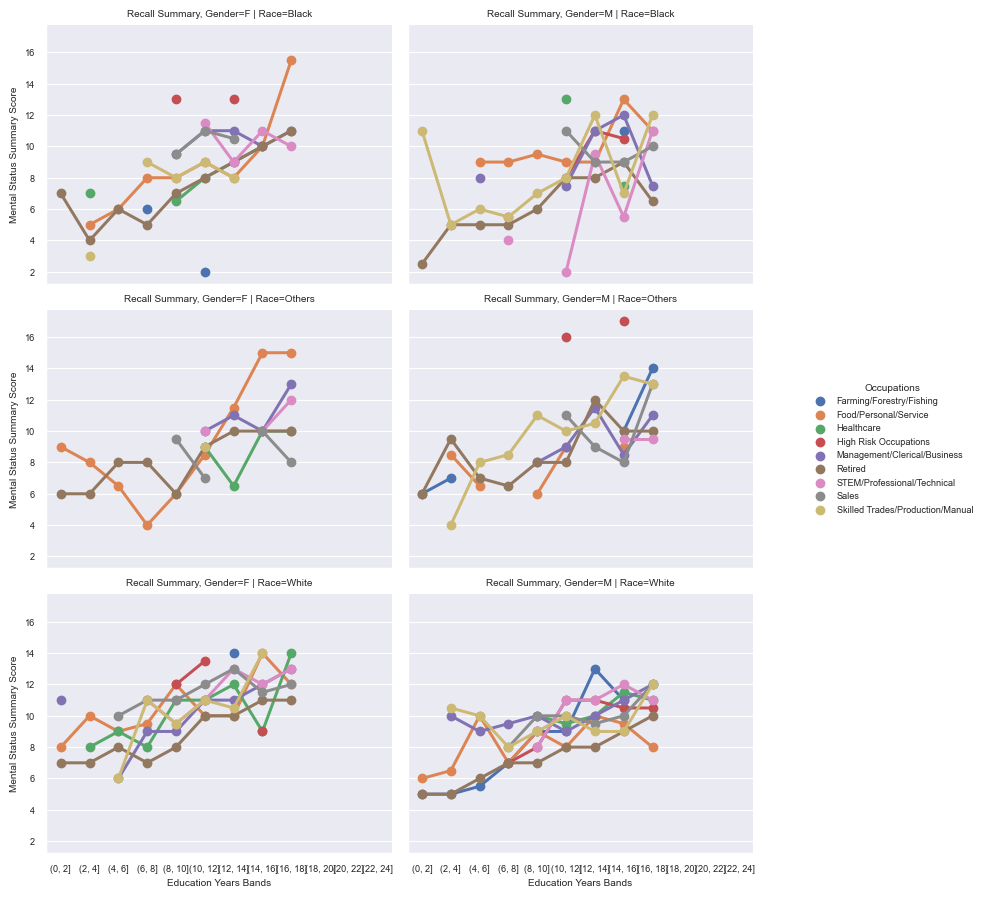

<Figure size 6000x4000 with 0 Axes>

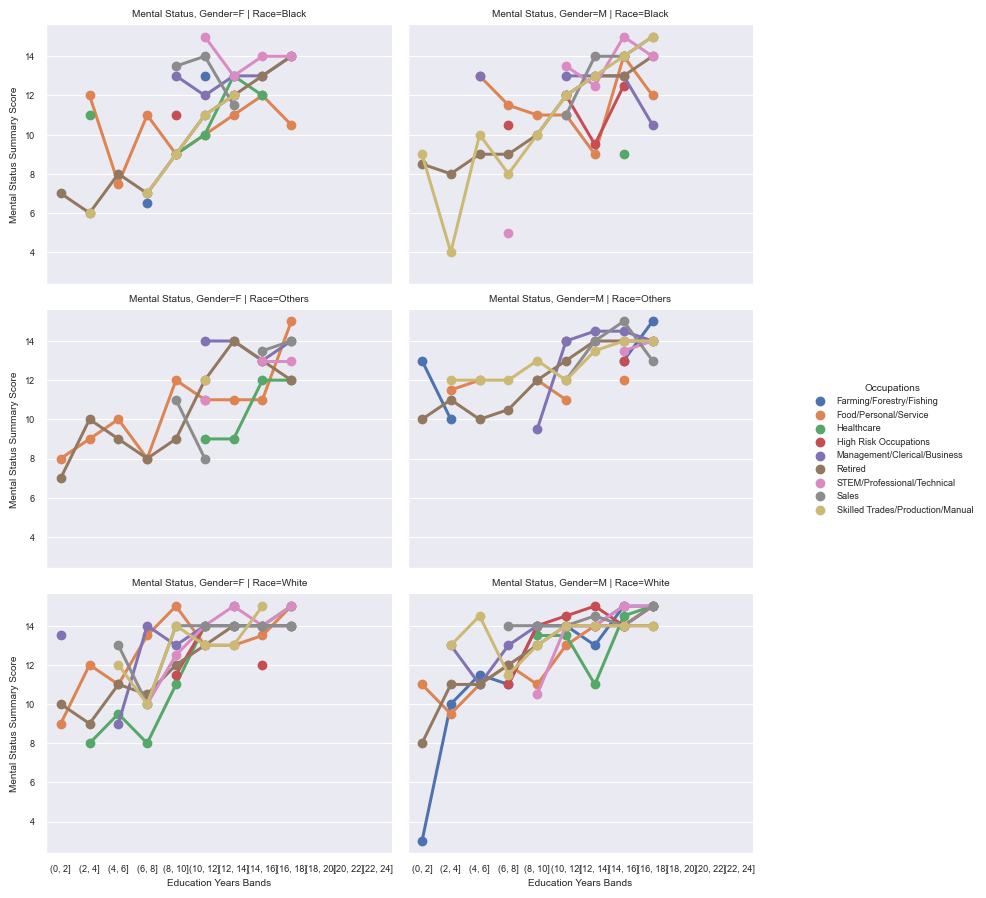

In [162]:
## Facet by Gender and Physical Race
median_df = df.groupby(['RwJOCCSD', 'RAEDYRS', 'RAGENDER', 'RARACEM'], as_index=False)['RwTR20'].median()

plt.figure(figsize = (60, 40))
sns.set_theme(context = "paper", font_scale = 0.75)
g = sns.FacetGrid(median_df, col='RAGENDER', row='RARACEM')
g.map_dataframe(sns.pointplot, x="RAEDYRS", y="RwTR20", 
      hue="RwJOCCSD", palette="deep")
g.add_legend(title="Occupations", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
g.set_titles("Recall Summary, Gender={col_name} | Race={row_name}")
g.set_axis_labels(x_var = "Education Years Bands", y_var= "Mental Status Summary Score")
plt.tight_layout()

## Median mental status Facet by Cognitive and Physical Limitations
median_df = df.groupby(['RwJOCCSD', 'RAEDYRS', 'RAGENDER', 'RARACEM'], as_index=False)['RwMSTOT'].median()

plt.figure(figsize = (60, 40))
sns.set_theme(context = "paper", font_scale = 0.75)
g = sns.FacetGrid(median_df, col='RAGENDER', row='RARACEM')
g.map_dataframe(sns.pointplot, x="RAEDYRS", y="RwMSTOT", 
      hue="RwJOCCSD", palette="deep")
g.add_legend(title="Occupations", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
g.set_titles("Mental Status, Gender={col_name} | Race={row_name}")
g.set_axis_labels(x_var = "Education Years Bands", y_var= "Mental Status Summary Score")
plt.tight_layout()

### 3.2.2 Facet by Siblings and Children

In [163]:
df.columns.to_list()

['HHIDPN',
 'Wave',
 'RwTR20',
 'RwMSTOT',
 'RwWORK',
 'RwJHOURS',
 'RwWGIHR',
 'RwJPHYS',
 'RwJLIFT',
 'RwJSTRES',
 'RwJSTOOP',
 'RwJSIGHT',
 'RwCENREG',
 'RwMSTAT',
 'RwAGEM_B',
 'RwLIVBRO',
 'RwHIBP',
 'RwDIAB',
 'RwCANCR',
 'RwLUNG',
 'RwHEART',
 'RwSTROK',
 'RwPSYCH',
 'RwATRAN',
 'RwVIGACT',
 'RwSMOKEV',
 'RwDRINK',
 'RwPhyLim',
 'RwCogLim',
 'RwJOCCSD',
 'RwAnyCogImp',
 'RwLOST',
 'RwWANDER',
 'RwHALUC',
 'RwALONE',
 'RwAgeBand',
 'RAGENDER',
 'RARACEM',
 'RAEDYRS',
 'RAEVBRN']

C:\Users\86139\AppData\Local\Temp\ipykernel_9204\4207240471.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_df = df.groupby(['RwJOCCSD', 'RAEDYRS', 'RAEVBRN', 'RwLIVBRO'], as_index=False)['RwTR20'].median()
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\c

<Figure size 6000x4000 with 0 Axes>

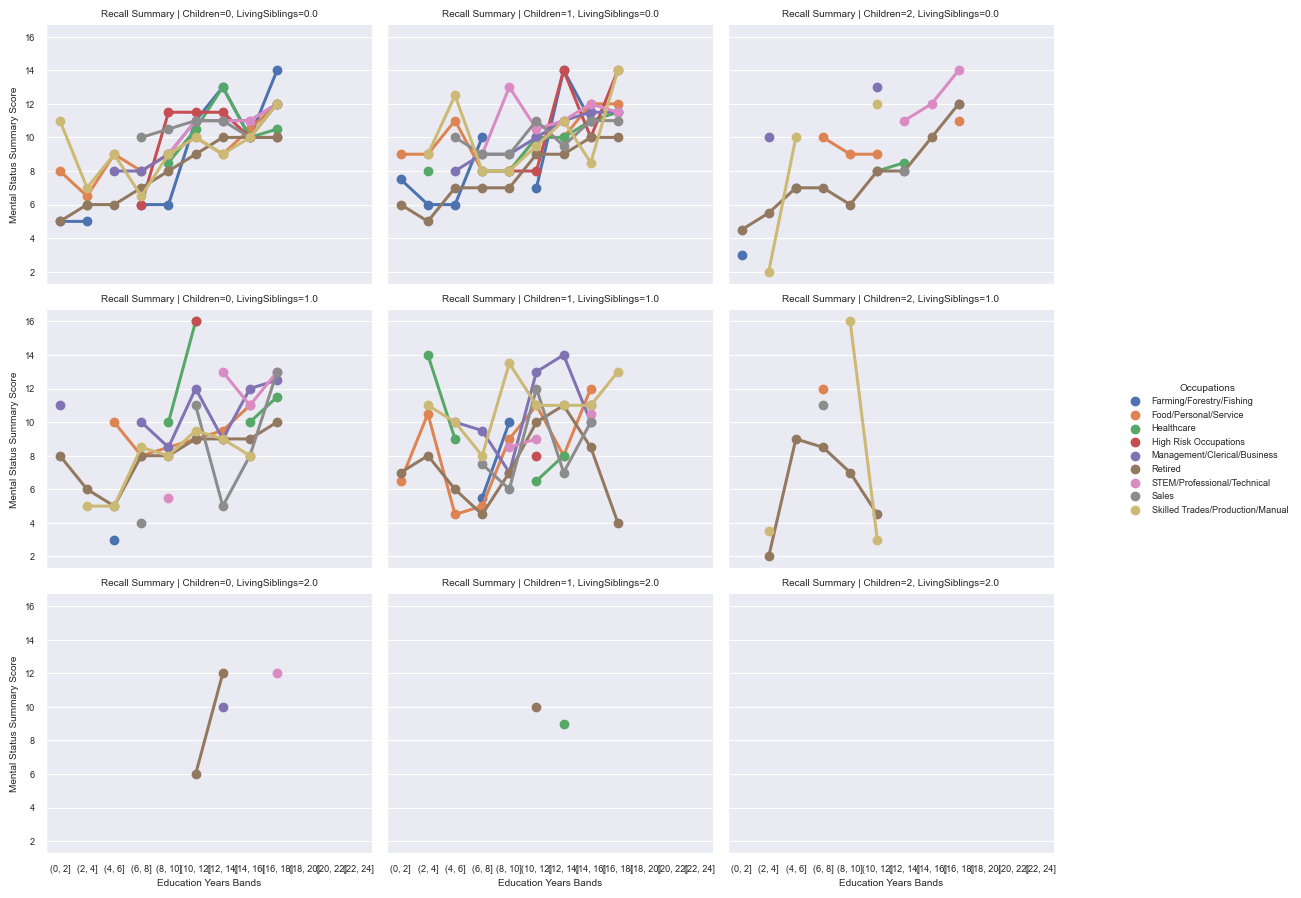

<Figure size 6000x4000 with 0 Axes>

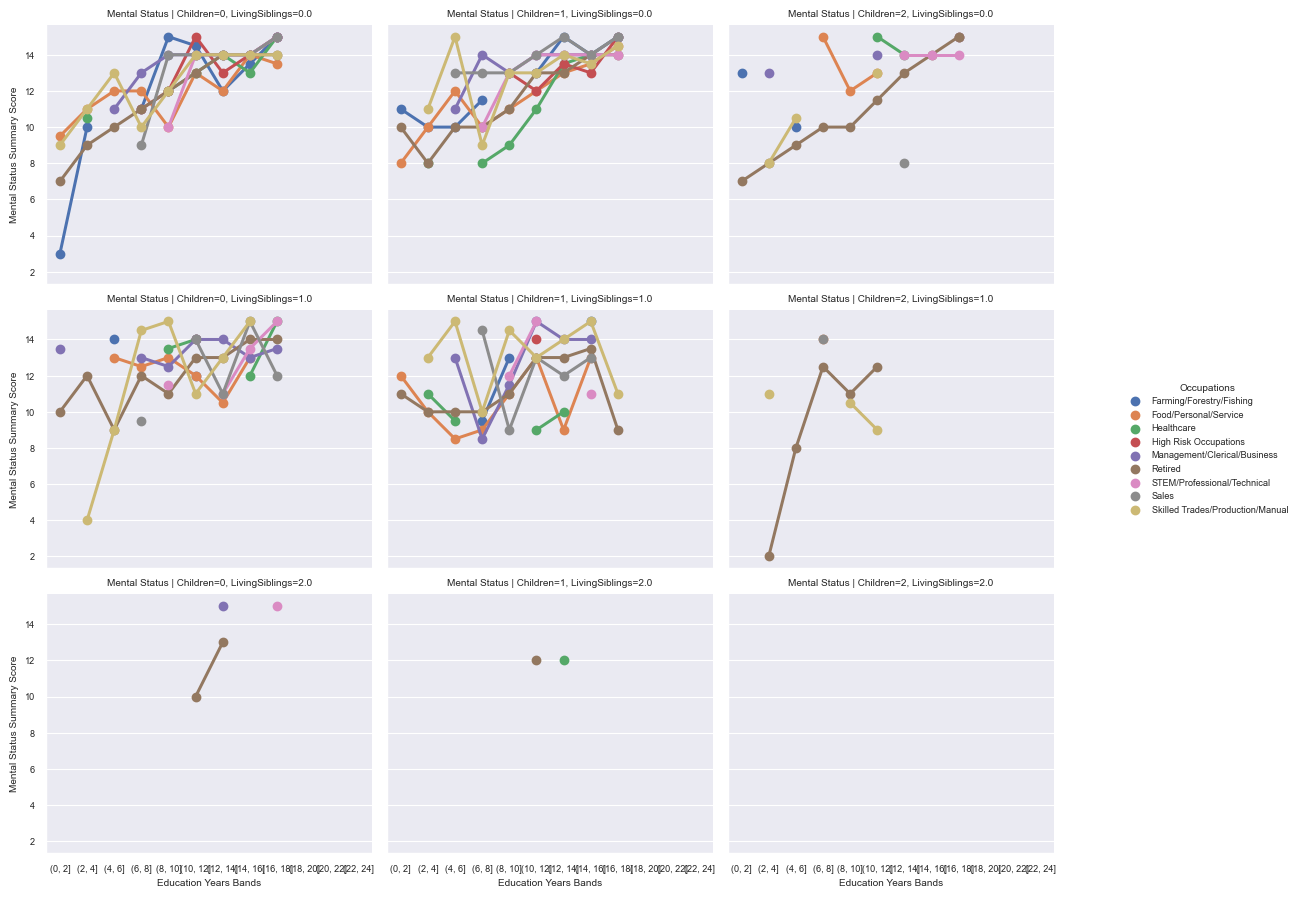

In [166]:
## Facet by Siblings and Children
median_df = df.groupby(['RwJOCCSD', 'RAEDYRS', 'RAEVBRN', 'RwLIVBRO'], as_index=False)['RwTR20'].median()

plt.figure(figsize = (60, 40))
sns.set_theme(context = "paper", font_scale = 0.75)
g = sns.FacetGrid(median_df, col='RAEVBRN', row='RwLIVBRO')
g.map_dataframe(sns.pointplot, x="RAEDYRS", y="RwTR20", 
      hue="RwJOCCSD", palette="deep")
g.add_legend(title="Occupations", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
g.set_titles("Recall Summary | Children={col_name}, LivingSiblings={row_name}")
g.set_axis_labels(x_var = "Education Years Bands", y_var= "Mental Status Summary Score")
plt.tight_layout()

## Median mental status Facet by Cognitive and Physical Limitations
median_df = df.groupby(['RwJOCCSD', 'RAEDYRS', 'RAEVBRN', 'RwLIVBRO'], as_index=False)['RwMSTOT'].median()

plt.figure(figsize = (60, 40))
sns.set_theme(context = "paper", font_scale = 0.75)
g = sns.FacetGrid(median_df, col='RAEVBRN', row='RwLIVBRO')
g.map_dataframe(sns.pointplot, x="RAEDYRS", y="RwMSTOT", 
      hue="RwJOCCSD", palette="deep")
g.add_legend(title="Occupations", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
g.set_titles("Mental Status | Children={col_name}, LivingSiblings={row_name}")
g.set_axis_labels(x_var = "Education Years Bands", y_var= "Mental Status Summary Score")
plt.tight_layout()

## 3.3.3 Only categorical Variables, Gender, grouped by Race, facet by Children and Siblings

C:\Users\86139\AppData\Local\Temp\ipykernel_9204\1198278028.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_df = df.groupby(['RwJOCCSD', 'RAGENDER', 'RARACEM', 'RAEVBRN', 'RwLIVBRO'], as_index=False)['RwTR20'].median()
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\86139\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packag

<Figure size 6000x4000 with 0 Axes>

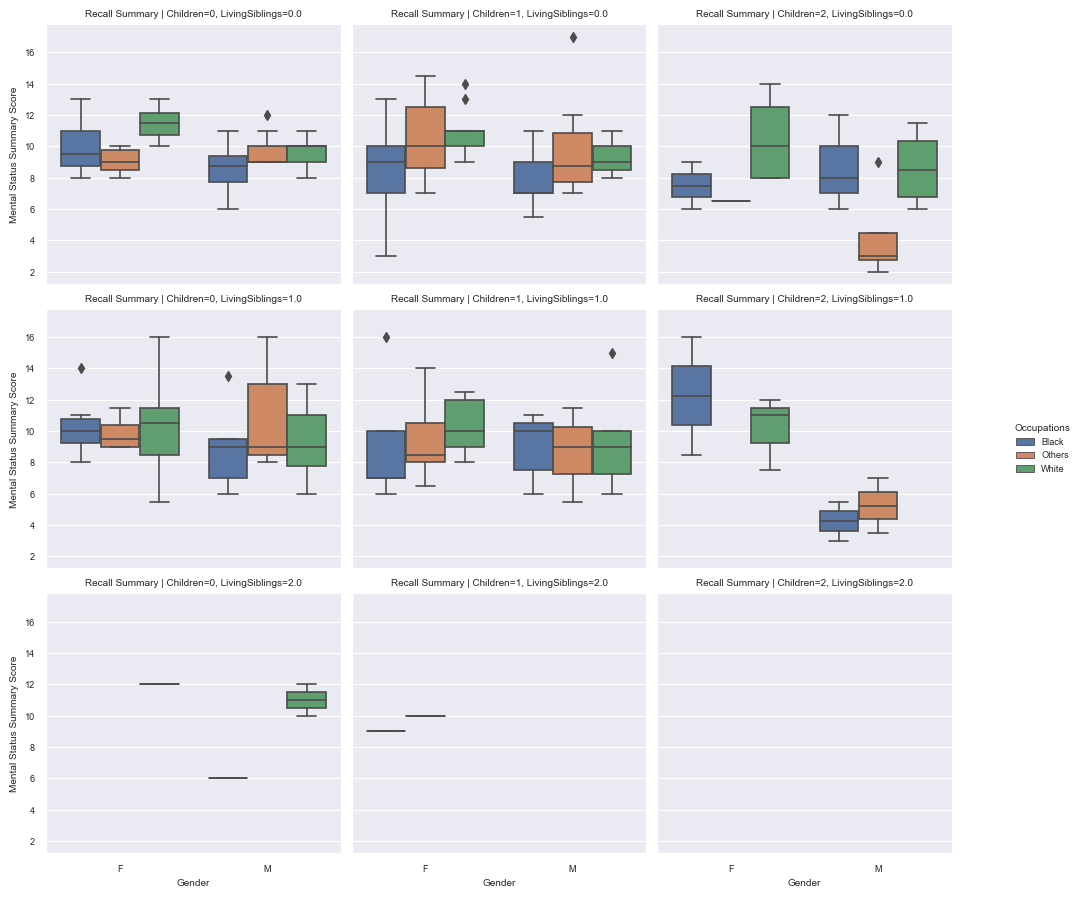

<Figure size 6000x4000 with 0 Axes>

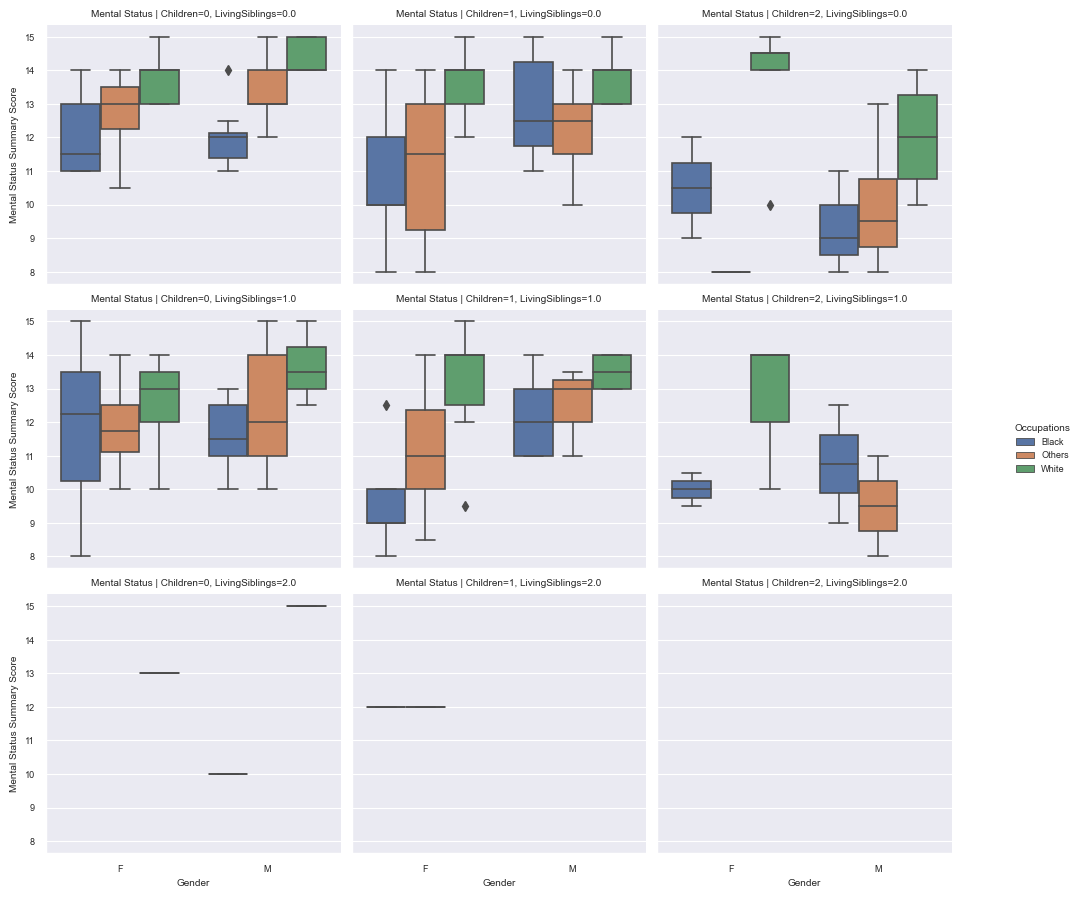

In [169]:
## Facet by Siblings and Children
median_df = df.groupby(['RwJOCCSD', 'RAGENDER', 'RARACEM', 'RAEVBRN', 'RwLIVBRO'], as_index=False)['RwTR20'].median()

plt.figure(figsize = (60, 40))
sns.set_theme(context = "paper", font_scale = 0.75)
g = sns.FacetGrid(median_df, col='RAEVBRN', row='RwLIVBRO')
g.map_dataframe(sns.boxplot, x='RAGENDER', y="RwTR20", 
      hue="RARACEM", palette="deep", color = "0.5")
g.add_legend(title="Occupations", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
g.set_titles("Recall Summary | Children={col_name}, LivingSiblings={row_name}")
g.set_axis_labels(x_var = "Gender", y_var= "Mental Status Summary Score")
plt.tight_layout()

## Median mental status Facet by Cognitive and Physical Limitations
median_df = df.groupby(['RwJOCCSD', 'RAGENDER', 'RARACEM', 'RAEVBRN', 'RwLIVBRO'], as_index=False)['RwMSTOT'].median()

plt.figure(figsize = (60, 40))
sns.set_theme(context = "paper", font_scale = 0.75)
g = sns.FacetGrid(median_df, col='RAEVBRN', row='RwLIVBRO')
g.map_dataframe(sns.boxplot, x="RAGENDER", y="RwMSTOT", 
      hue="RARACEM", palette="deep", color = "0.5")
g.add_legend(title="Occupations", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
g.set_titles("Mental Status | Children={col_name}, LivingSiblings={row_name}")
g.set_axis_labels(x_var = "Gender", y_var= "Mental Status Summary Score")
plt.tight_layout()